# Projeto 2 - NLP

-----

 Usaremos os algoritmos aprendidos e as técnicas vistas na segunda parte do curso para extrairmos informações relevantes de texto. Mais precisamente, de publicações no Twitter.

## Os Dados

Utilizaremos um Dataset obtido do Twitter com 100K postagens entre os dias 01/08/2018 e 20/10/2018. Cada postagem é classificada como **positiva**, **negativa** ou **neutra**.  

Descrição das colunas:

- **id**: ID único para o tweet  
- **tweet_text**: Texto da publicação no Twitter  
- **tweet_date**: Data da publicação no Twitter  
- **sentiment**: 0, se negativo; 1, se positivo; 2, se neutro  
- **query_used**: Filtro utilizado para buscar a publicação

## O Problema

Você deverá desenvolver um modelo para detectar o sentimento de uma publicação do Twitter a classificando em uma das três categorias: **positiva**, **negativa** ou **neutra**. O texto da publicação está disponível na coluna "tweet_text". Teste pelo menos 2 técnicas de NLP diferentes e escolha a métrica de avaliação que julgar mais pertinente.  

Para ajudar no desenvolvimento, é possível dividir o projeto em algumas fases:

- **Análise de consistência dos dados**: analise se os dados estão fazendo sentido, se os campos estão completos e se há dados duplicados ou faltantes. Se julgar necessário, trate-os.    


- **Análise exploratória**: analise a sua base como um todo, verifique o balanceamento entre as classes e foque, principalmente, na coluna ```tweet_text```.    


- **Pré-processamento e transformações**: projetos de NLP exigem um considerável pré-processamento. Foque no tratamento da string do texto. Procure começar com tratamentos simples e adicione complexidade gradualmente. Nessa etapa você testará diferentes técnicas de transformações, como o Bag Of Words e o TF-IDF.    


- **Treinamento do modelo**: depois das transformações, você poderá executar o treinamento do modelo classificador. Nessa etapa o problema se torna semelhante aos abordados na primeira parte do módulo. Você pode testar diversos classificadores como RandomForest, AdaBoost, entre outros. Otimize os hiperparâmetros do modelo com técnicas como a GridSearch e a RandomizedSearch.    


- **Conclusões**: descreva, em texto, as conclusões sobre os seus estudos. O modelo é capaz de identificar o sentimento das publicações? É possível extrapolar o modelo para outros contextos, como a análise de sentimento de uma frase qualquer? Pense em questões pertinentes e relevantes que você tenha obtido durante o desenvolvimento do projeto!     



## Dicas
     

### Tente encontrar possíveis vieses

É muito comum que modelos de NLP possuam fortes vieses, como a tendência de relacionar palavras específicas com alguma classe de saída. Tente encontrar vieses no seu estudo, isso pode ajudar a tirar boas conclusões. o campo "query_used" pode ser útil para essa análise.  

### O pré-processamento é a chave para um bom desempenho

Essa é a etapa que mais vai contribuir para o desempenho do seu modelo. Seja criativo e desenvolva essa etapa de uma maneira que seja fácil de aplicar o mesmo processamento para uma nova base, você terá que fazer isso para gerar a base de submissão.

-------

In [3]:
%pip install spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import spacy
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from unidecode import unidecode
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.metrics import classification_report
from nltk import pos_tag
import emoji
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from nltk.stem import RSLPStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
#load the cvs and transform into dataset
tweet = pd.read_csv('./Dados/train/Train3Classes.csv', sep = ',')
#dataset visualization
tweet

FileNotFoundError: [Errno 2] No such file or directory: './Dados/train/Train3Classes.csv'

### Data consistence evaluation

In [ ]:
#Geting info about the types and absents data
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          95000 non-null  int64 
 1   tweet_text  95000 non-null  object
 2   tweet_date  95000 non-null  object
 3   sentiment   95000 non-null  int64 
 4   query_used  95000 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.6+ MB


In [ ]:
#Verifying if there'is duplicated data
tweet.duplicated().value_counts()

False    95000
dtype: int64

### EDA

In [ ]:
#Verifying if the data is balanced
tweet['sentiment'].value_counts()

0    31696
1    31678
2    31626
Name: sentiment, dtype: int64

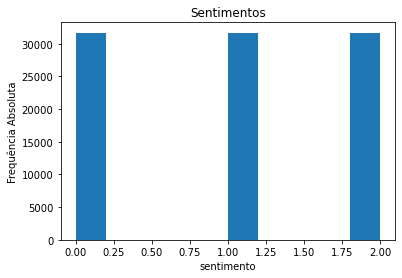

In [ ]:
#Grafic view about setiment column
plt.title('Sentimentos')
plt.xlabel('sentimento')
plt.ylabel('Frequência Absoluta')
plt.hist(tweet['sentiment'], 10)
plt.show()

In [ ]:
tweet = tweet.sample(frac=0.05, replace=False)

### Pre processing and transformations

In [ ]:
def limpezaTexto(string):
    import spacy
    nlp = spacy.load("pt_core_news_sm")
    from nltk.corpus import stopwords
    words_pt = nltk.corpus.stopwords.words('portuguese')
    import emoji
    happy =  re.sub(r'[:.][)]', 'feliz', string) #char replace: from  :) to feliz
    happy_D =  re.sub(r'[:.][D]', 'feliz', happy)#char replace: from  :D to feliz
    sad = re.sub(r'[:.][(]', 'triste', happy_D) #char replace: from  :() to triste
    html = re.sub(r'ht.*/.*', ' ', sad)#removal of hyperlinks
    unicode = unidecode(html)#removal of Grafic accentuations
    emoji = emoji.demojize(unicode)#emojis transform to code
    no_emoji = re.sub(r'[:][\w]*[:]', " ", emoji)#removal of generic emojis
    no_arroba = re.sub(r'[\Wa-zA-Z0-9]*[\W][@][\w.]+|[@.][\w.]+', ' ', no_emoji)#quote removal
    especial = re.sub(r'[^a-zA-Z0-9]+', ' ', no_arroba)#specials chars removal
    no_number = re.sub(r'[\d]', ' ', especial)#digits removal
    doc = nlp(no_number)#lemmatization instance  
    tokens = [token.lemma_.lower() for token in doc] #lemmatization. The consequence is the string tokenization too
    for palavra in tokens: #loop to stopwords removals from dataset
        if palavra in tokens:
            i = tokens.index(palavra)
            tokens.pop(i)
    return tokens

In [ ]:
#applying the datacleaning function and doing a join on the strings list
tweet['tweet_text'] = tweet['tweet_text'].apply(lambda x: limpezaTexto(x))
tweet['tweet_text'] = tweet['tweet_text'].apply(lambda x: ' '.join(x))

In [ ]:
#Cleaned dataset view
tweet

In [ ]:
# Slicing the dataset in text and target
X = tweet['tweet_text']
y = tweet['sentiment']



# slicing the dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                     y,
                                                     test_size = 0.3,
                                                     random_state = 42)

In [ ]:
#applying the TfIdf vectorizer
tfidf = TfidfVectorizer(use_idf = True)

X_train_tfidf = tfidf.fit_transform(X_train).todense()
X_test_tfidf  = tfidf.transform(X_test).todense()

### Model trainning

In [ ]:
# models instances
modelMultinomial = MultinomialNB()
modelGaussian = GaussianNB()
modelRandomforest = RandomForestClassifier()
modelSVC = LinearSVC()

# fitting the models
modelMultinomial.fit(X_train_tfidf, y_train)
modelGaussian.fit(X_train_tfidf, y_train)
modelRandomforest.fit(X_train_tfidf, y_train)
modelSVC.fit(X_train_tfidf, y_train)

# Predictions generates
y_predMultinomial = modelMultinomial.predict(X_test_tfidf)
y_predGaussian = modelGaussian.predict(X_test_tfidf)
y_predRandomforest = modelRandomforest.predict(X_test_tfidf)
y_predSVC = modelSVC.predict(X_test_tfidf)


### Valuation with standard models

In [ ]:
# Report prints 
print('Model: Multinomial')
print(classification_report(y_test, y_predMultinomial))
print("#"*80)
print('Model: Gaussiano')
print(classification_report(y_test, y_predGaussian))
print("#"*80)
print('Model: RandomForest')
print(classification_report(y_test, y_predRandomforest))
print("#"*80)
print('Model: SVC')
print(classification_report(y_test, y_predSVC))


In [ ]:
text = 'A felicidade chegou e ficou'
y_predMultinomial = modelMultinomial.predict(text)
y_predMultinomial

### Tunning the models with Hyperparameters 

### Implications